In [360]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [361]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40475 entries, 0 to 40474
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     40475 non-null  object 
 1   description               40475 non-null  object 
 2   summary                   40463 non-null  object 
 3   installs                  40475 non-null  object 
 4   minInstalls               40475 non-null  float64
 5   score                     40475 non-null  float64
 6   ratings                   40475 non-null  float64
 7   reviews                   40475 non-null  float64
 8   histogram                 40475 non-null  object 
 9   price                     40475 non-null  float64
 10  free                      40475 non-null  int64  
 11  currency                  40475 non-null  object 
 12  sale                      40475 non-null  bool   
 13  offersIAP                 40475 non-null  bool   
 14  inAppP

In [362]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video']]

y = df['score']

In [363]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr,test_size=.20, random_state=10)

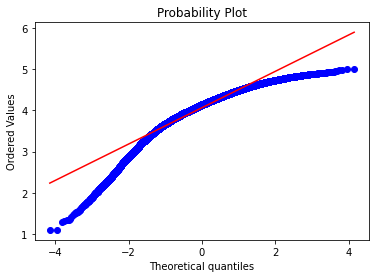

In [364]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

## Testing with pipeline

In [365]:
## Define pipeline transformers 

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first',sparse='false'))])

In [366]:
numeric_features = X.select_dtypes(include=['int64','float64']).columns

categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [367]:
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear', LinearRegression())])

In [368]:
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ratings', 'free', 'containsAds', 'editorsChoice', 'year',
       'top_developer', 'installs_day', 'updated_days', 'has_video'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse='false'))]),
                                                  Index(['genre', 'contentRating'], dtype='object'))])),
                ('linear', LinearRegression())])

In [369]:
y_pred = lr.predict(X_val)

In [370]:
lr.score(X_val,y_val)
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val, y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.17
MSE of linear regression on val set: 0.42


In [371]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val.columns, lr['linear'].coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.09
free : -0.01
containsAds : 0.04
genre : 0.00
editorsChoice : 0.02
contentRating : 0.10
year : -0.01
top_developer : -0.04
installs_day : 0.03
updated_days : -0.02
has_video : 0.06


## No pipeline

In [373]:
X_train_cont = X_train[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video']]
X_val_cont = X_val[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video']]

In [374]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(X_train[['genre','contentRating']])

ohe_x_train = ohe.transform(X_train[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_train_df = pd.DataFrame(ohe_x_train, columns=columns, index=X_train.index)

In [375]:
ohe_v = OneHotEncoder(drop='first', sparse=False)

ohe_v.fit(X_val[['genre','contentRating']])

ohe_x_val = ohe_v.transform(X_val[['genre','contentRating']])

columns_v = ohe_v.get_feature_names(['genre','contentRating'])

ohe_x_val_df = pd.DataFrame(ohe_x_val, columns=columns_v, index=X_val.index)

In [376]:
#Merge cont and cat DFs
combo_train_df = pd.concat([X_train_cont, ohe_x_train_df], axis=1)

combo_val_df =  pd.concat([X_val_cont, ohe_x_val_df], axis=1)

In [377]:
lr = LinearRegression()

lr.fit(combo_train_df, y_train)

y_pred = lr.predict(combo_val_df)
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(combo_val_df, y_val)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.14
MSE of linear regression on val set: 0.43


In [378]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df.columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.17
containsAds : 0.08
editorsChoice : 0.18
year : 0.00
top_developer : 0.64
installs_day : 0.00
updated_days : -0.00
has_video : 0.08
genre_Adventure : -0.02
genre_Arcade : 0.06
genre_Art & Design : 0.09
genre_Auto & Vehicles : 0.12
genre_Beauty : -0.06
genre_Board : 0.11
genre_Books & Reference : 0.27
genre_Business : 0.15
genre_Card : 0.24
genre_Casino : 0.35
genre_Casual : 0.04
genre_Comics : -0.05
genre_Communication : 0.03
genre_Dating : -0.19
genre_Education : 0.17
genre_Entertainment : -0.06
genre_Events : 0.01
genre_Finance : 0.09
genre_Food & Drink : 0.15
genre_Health & Fitness : 0.21
genre_House & Home : -0.05
genre_Libraries & Demo : 0.09
genre_Lifestyle : 0.11
genre_Maps & Navigation : 0.06
genre_Medical : 0.16
genre_Music : -0.01
genre_Music & Audio : 0.11
genre_News & Magazines : -0.04
genre_Parenting : 0.20
genre_Personalization : 0.23
genre_Photography : -0.03
genre_Productivity : 0.08
genre_Puzzle : 0.20
genre_Racing : 0.01
genr

In [379]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(combo_val_df)
check['resid'] = check['pred'] - check['score']

In [380]:
check.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,score,pred,resid
25335,2850.0,1,0,Travel & Local,0,Everyone,2013,0,181.686047,142,1,1.536842,4.042002,2.505160
37077,41646.0,1,0,Education,0,Everyone,2014,0,419.815281,51,1,1.696547,4.153073,2.456526
34086,8943.0,1,0,Finance,0,Everyone,2016,0,298.864316,1,0,1.571865,4.000657,2.428791
30889,6117.0,1,1,Lifestyle,0,Everyone,2019,0,1430.615165,194,0,1.696825,4.092750,2.395925
24853,5434.0,1,1,Entertainment,0,Everyone,2014,0,435.161010,603,0,1.541436,3.883505,2.342068
38582,1483.0,1,0,Libraries & Demo,0,Everyone,2011,0,269.978402,115,0,1.675676,3.976532,2.300857
27164,3758.0,1,1,Simulation,0,Everyone,2016,0,568.504832,203,0,1.589474,3.874222,2.284748
24850,4617.0,1,1,Entertainment,0,Everyone,2015,0,235.515780,1224,0,1.575693,3.835228,2.259535
31560,8671.0,1,1,Photography,0,Everyone,2020,0,2793.296089,4,0,1.788654,3.976915,2.188261
11664,6167.0,1,0,Finance,0,Everyone,2010,0,267.952840,1,0,1.809032,3.991780,2.182748


In [381]:
check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,score,pred,resid
8435,48145.0,1,1,Card,0,Teen,2017,0,375.375375,278,1,4.230178,4.275693,0.045514
37970,1942.0,1,1,Tools,0,Everyone,2017,0,428.082192,177,1,4.092308,4.109004,0.016696
25190,15512.0,1,1,Casual,0,Teen,2017,0,677.506775,221,1,4.029601,4.078009,0.048408
26446,13395.0,1,1,Action,0,Everyone,2014,0,385.653683,262,1,4.137416,4.047416,-0.090000
5180,13824.0,1,1,Puzzle,0,Everyone,2017,0,3816.793893,63,0,4.119392,4.205183,0.085790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26141,2530.0,1,1,Tools,0,Everyone,2020,1,2551.020408,6,0,4.683795,4.697006,0.013212
37123,9612.0,1,1,Arcade,0,Everyone,2016,0,3001.200480,196,1,4.118503,4.128238,0.009735
28243,20369.0,1,1,Video Players & Editors,0,Everyone,2019,0,13605.442177,23,0,4.041707,3.966555,-0.075152
24558,7185.0,1,1,Tools,0,Everyone,2019,0,1697.792869,2,0,4.130137,4.051043,-0.079094


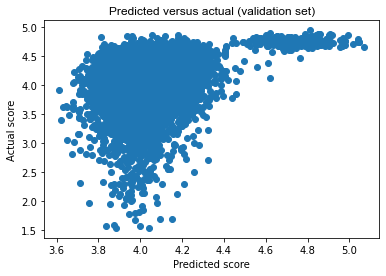

In [382]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

Specifically, way over predicting the lower scoring apps - typically earleir years

## Testing with apps below 2.5 score dropped

In [383]:
df_copy = df.copy()
df_copy = df_copy[df_copy['score'] >= 2.5]

In [384]:
X2 = df_copy[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer','installs_day','updated_days','has_video']]

y2 = df_copy['score']

In [385]:
# Split to create temporary tr and test 
X_tr2, X_test2, y_tr2, y_test2 = train_test_split(X2, y2,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_tr2, y_tr2,test_size=.20, random_state=10)

In [386]:
X_train_cont2 = X_train2[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video']]
X_val_cont2 = X_val2[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video']]

In [387]:
ohe2 = OneHotEncoder(drop='first', sparse=False)

ohe2.fit(X_train2[['genre','contentRating']])

ohe_x_train2 = ohe2.transform(X_train2[['genre','contentRating']])

columns2 = ohe2.get_feature_names(['genre','contentRating'])

ohe_x_train_df2 = pd.DataFrame(ohe_x_train2, columns=columns2, index=X_train2.index)

In [388]:
ohe_v2 = OneHotEncoder(drop='first', sparse=False)

ohe_v2.fit(X_val2[['genre','contentRating']])

ohe_x_val2 = ohe_v2.transform(X_val2[['genre','contentRating']])

columns_v2 = ohe_v2.get_feature_names(['genre','contentRating'])

ohe_x_val_df2 = pd.DataFrame(ohe_x_val2, columns=columns_v2, index=X_val2.index)

In [389]:
#Merge cont and cat DFs
combo_train_df2 = pd.concat([X_train_cont2, ohe_x_train_df2], axis=1)

combo_val_df2 =  pd.concat([X_val_cont2, ohe_x_val_df2], axis=1)

In [390]:
lr2 = LinearRegression()

lr2.fit(combo_train_df2, y_train2)

y_pred2 = lr2.predict(combo_val_df2)
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(combo_val_df2, y_val2)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val2, y_pred2))))

R^2 of linear regression on val set: 0.16
MSE of linear regression on val set: 0.39


In [391]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df2.columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.17
containsAds : 0.07
editorsChoice : 0.16
year : 0.00
top_developer : 0.62
installs_day : 0.00
updated_days : -0.00
has_video : 0.07
genre_Adventure : -0.02
genre_Arcade : 0.08
genre_Art & Design : 0.06
genre_Auto & Vehicles : 0.11
genre_Beauty : -0.10
genre_Board : 0.11
genre_Books & Reference : 0.26
genre_Business : 0.13
genre_Card : 0.24
genre_Casino : 0.35
genre_Casual : 0.04
genre_Comics : -0.06
genre_Communication : 0.06
genre_Dating : -0.06
genre_Education : 0.16
genre_Entertainment : -0.02
genre_Events : 0.14
genre_Finance : 0.12
genre_Food & Drink : 0.14
genre_Health & Fitness : 0.21
genre_House & Home : 0.09
genre_Libraries & Demo : -0.04
genre_Lifestyle : 0.12
genre_Maps & Navigation : 0.08
genre_Medical : 0.20
genre_Music : -0.00
genre_Music & Audio : 0.13
genre_News & Magazines : -0.01
genre_Parenting : 0.22
genre_Personalization : 0.21
genre_Photography : -0.01
genre_Productivity : 0.10
genre_Puzzle : 0.20
genre_Racing : -0.01
gen

In [392]:
check2 = X_val2.copy()
check2['score'] = y_val2
check2['pred'] = lr2.predict(combo_val_df2)
check2['resid'] = check2['pred'] - check2['score']

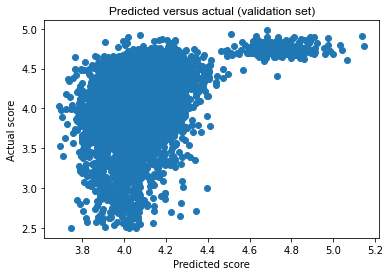

In [393]:
fig, ax = plt.subplots()
plt.scatter(y_pred2,y_val2)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

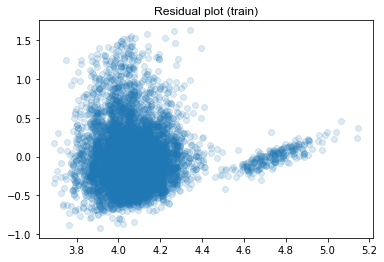

In [394]:
plt.scatter(check2['pred'],check2['resid'],alpha = 0.15)
plt.title('Residual plot (train)',family='arial',fontsize=12);

In [395]:
small_cluster_df = check2[check2['pred'] >= 4.5]

In [396]:
check2.groupby('top_developer').count()

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,installs_day,updated_days,has_video,score,pred,resid
top_developer,,,,,,,,,,,,,
0,6198,6198,6198,6198,6198,6198,6198,6198,6198,6198,6198,6198,6198
1,219,219,219,219,219,219,219,219,219,219,219,219,219


In [397]:
small_cluster_df.groupby('top_developer').count()

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,installs_day,updated_days,has_video,score,pred,resid
top_developer,,,,,,,,,,,,,
1,216,216,216,216,216,216,216,216,216,216,216,216,216


In [398]:
check2.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,score,pred,resid
4458,9660.0,1,1,Word,0,Teen,2019,0,1848.428835,314,1,2.713697,4.341993,1.628295
22534,1220.0,1,1,Medical,0,Everyone,2019,0,900.900901,207,1,2.647541,4.265104,1.617563
10445,2946.0,1,1,Education,0,Everyone,2011,0,147.449130,307,0,2.560403,4.135808,1.575405
39065,3647.0,1,0,Lifestyle,0,Everyone,2020,0,1213.592233,35,0,2.502732,4.058264,1.555532
24924,4524.0,1,0,Maps & Navigation,0,Everyone,2016,0,267.952840,42,1,2.546610,4.077746,1.531136
3621,1144.0,1,1,Photography,0,Everyone,2017,0,351.370344,113,1,2.530435,4.057105,1.526670
3975,31591.0,1,1,Books & Reference,0,Mature 17+,2018,0,1245.330012,33,0,2.700556,4.224713,1.524157
6140,3741.0,1,1,Video Players & Editors,0,Everyone,2015,0,257.731959,100,1,2.502674,4.021524,1.518850
6078,2303.0,1,0,Shopping,0,Everyone,2014,0,213.675214,50,0,2.526087,4.042422,1.516335
3196,10185.0,1,1,News & Magazines,0,Everyone 10+,2012,0,163.666121,9,0,2.515717,4.010498,1.494781


## Breaking out group

In [399]:
df_analysis = check2[check2['pred'] < 4.5]

In [400]:
df_analysis

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,score,pred,resid
20862,83545.0,1,0,Tools,0,Everyone,2012,0,328.407225,155,1,4.169836,4.056250,-0.113586
35526,8146.0,1,1,Entertainment,0,Everyone,2016,0,596.658711,1140,0,2.965602,3.900112,0.934510
12444,2886.0,1,1,Medical,0,Everyone,2013,0,173.010381,461,0,4.295139,4.168445,-0.126694
37191,3165.0,1,1,Board,0,Everyone,2016,0,314.663310,839,0,4.218354,4.052248,-0.166106
12679,63911.0,1,0,Business,0,Everyone,2015,0,2294.630564,12,0,4.354814,4.071682,-0.283131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39566,30051.0,1,1,Sports,0,Everyone,2017,0,3394.433130,334,0,3.267662,4.029375,0.761713
12991,3770.0,1,0,Travel & Local,0,Everyone,2014,0,395.256917,36,0,4.169761,4.011402,-0.158359
40254,1886.0,1,1,Simulation,0,Everyone,2016,0,296.559905,189,0,3.372340,3.892784,0.520444
32911,9637.0,1,1,Action,0,Everyone 10+,2020,0,1278.772379,332,0,4.376811,4.009082,-0.367729


## Testing with specific columns for genre - all apps

In [401]:
df_3 = df.copy()

In [402]:
df_3['action'] = np.where(df_3['genre'] == 'Action',1,0)
df_3['book_ref'] = np.where(df_3['genre'] == 'Books & Reference',1,0)
df_3['business'] = np.where(df_3['genre'] == 'Business',1,0)
df_3['card'] = np.where(df_3['genre'] == 'Card',1,0)
df_3['casino'] = np.where(df_3['genre'] == 'Casino',1,0)
df_3['comics'] = np.where(df_3['genre'] == 'Comics',1,0)
df_3['dating'] = np.where(df_3['genre'] == 'Dating',1,0)
df_3['education'] = np.where(df_3['genre'] == 'Education',1,0)
df_3['finance'] = np.where(df_3['genre'] == 'Finance',1,0)
df_3['food_drink'] = np.where(df_3['genre'] == 'Food & Drink',1,0)
df_3['health_fit'] = np.where(df_3['genre'] == 'Health & Fitness',1,0)
df_3['lib_demo'] = np.where(df_3['genre'] == 'Libraries & Demo',1,0)
df_3['puzzle'] = np.where(df_3['genre'] == 'Puzzle',1,0)
df_3['simulation'] = np.where(df_3['genre'] == 'Simulation',1,0)
df_3['weather'] = np.where(df_3['genre'] == 'Weather',1,0)
df_3['word'] = np.where(df_3['genre'] == 'Word',1,0)
df_3['vid_edit'] = np.where(df_3['genre'] == 'Video Players & Editors',1,0)

In [403]:
X3 = df_3[['ratings','free','containsAds','editorsChoice','contentRating','year','top_developer','installs_day',
           'updated_days','has_video',
          'action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

y3 = df_3['score']

In [404]:
# Split to create temporary tr and test 
X_tr3, X_test3, y_tr3, y_test3 = train_test_split(X3, y3,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_tr3, y_tr3,test_size=.20, random_state=10)

In [405]:
X_train_cont3 = X_train3[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video',
          'action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

X_val_cont3 = X_val3[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video',
          'action', 'book_ref','business','card','casino','comics','dating','education','finance','food_drink',
          'health_fit','lib_demo','puzzle','simulation','weather','word','vid_edit']]

In [406]:
ohe3 = OneHotEncoder(drop='first', sparse=False)

ohe3.fit(X_train3[['contentRating']])

ohe_x_train3 = ohe3.transform(X_train3[['contentRating']])

columns3 = ohe3.get_feature_names(['contentRating'])

ohe_x_train_df3 = pd.DataFrame(ohe_x_train3, columns=columns3, index=X_train3.index)

In [407]:
ohe_v3 = OneHotEncoder(drop='first', sparse=False)

ohe_v3.fit(X_val3[['contentRating']])

ohe_x_val3 = ohe_v3.transform(X_val3[['contentRating']])

columns_v3 = ohe_v3.get_feature_names(['contentRating'])

ohe_x_val_df3 = pd.DataFrame(ohe_x_val3, columns=columns_v3, index=X_val3.index)

In [408]:
#Merge cont and cat DFs
combo_train_df3 = pd.concat([X_train_cont3, ohe_x_train_df3], axis=1)

combo_val_df3 =  pd.concat([X_val_cont3, ohe_x_val_df3], axis=1)

In [409]:
combo_val_df3

,free,containsAds,editorsChoice,year,top_developer,installs_day,updated_days,has_video,action,book_ref,...,health_fit,lib_demo,puzzle,simulation,weather,word,vid_edit,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen
10985,1,1,0,2020,0,2890.173410,22,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
39902,1,0,1,2017,1,717.875090,8,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
15793,1,1,0,2014,0,219.587176,447,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
8435,1,1,0,2017,0,375.375375,278,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0
14863,1,1,0,2013,0,350.631136,52,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35732,1,1,0,2015,0,483.091787,4,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
20731,1,1,0,2014,0,193.723363,2,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
5111,1,1,0,2011,0,296.912114,576,1,0,0,...,0,0,0,0,0,0,0,0.0,1.0,0.0
27268,1,1,0,2019,0,1349.527665,76,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,1.0


In [410]:
lr3 = LinearRegression()

lr3.fit(combo_train_df3, y_train3)

y_pred3 = lr3.predict(combo_val_df3)
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(combo_val_df3, y_val3)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val3, y_pred3))))

R^2 of linear regression on val set: 0.13
MSE of linear regression on val set: 0.43


In [411]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df3.columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -0.16
containsAds : 0.08
editorsChoice : 0.18
year : 0.00
top_developer : 0.65
installs_day : 0.00
updated_days : -0.00
has_video : 0.08
action : -0.05
book_ref : 0.21
business : 0.08
card : 0.19
casino : 0.30
comics : -0.11
dating : -0.24
education : 0.11
finance : 0.03
food_drink : 0.09
health_fit : 0.15
lib_demo : 0.02
puzzle : 0.15
simulation : -0.15
weather : 0.15
word : 0.23
vid_edit : -0.14
contentRating_Everyone 10+ : 0.03
contentRating_Mature 17+ : -0.02
contentRating_Teen : -0.03


In [412]:
check3 = X_val3.copy()
check3['score'] = y_val3
check3['pred'] = lr3.predict(combo_val_df3)
check3['resid'] = check3['pred'] - check3['score']

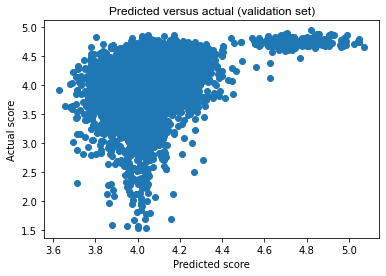

In [413]:
fig, ax = plt.subplots()
plt.scatter(y_pred3,y_val3)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

In [414]:
check3.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,...,health_fit,lib_demo,puzzle,simulation,weather,word,vid_edit,score,pred,resid
25335,2850.0,1,0,0,Everyone,2013,0,181.686047,142,1,...,0,0,0,0,0,0,0,1.536842,4.037795,2.500953
37077,41646.0,1,0,0,Everyone,2014,0,419.815281,51,1,...,0,0,0,0,0,0,0,1.696547,4.159743,2.463195
24853,5434.0,1,1,0,Everyone,2014,0,435.161010,603,0,...,0,0,0,0,0,0,0,1.541436,4.000377,2.458941
34086,8943.0,1,0,0,Everyone,2016,0,298.864316,1,0,...,0,0,0,0,0,0,0,1.571865,4.000875,2.429009
24850,4617.0,1,1,0,Everyone,2015,0,235.515780,1224,0,...,0,0,0,0,0,0,0,1.575693,3.952326,2.376633
30889,6117.0,1,1,0,Everyone,2019,0,1430.615165,194,0,...,0,0,0,0,0,0,0,1.696825,4.037563,2.340737
38582,1483.0,1,0,0,Everyone,2011,0,269.978402,115,0,...,0,1,0,0,0,0,0,1.675676,3.982330,2.306654
27164,3758.0,1,1,0,Everyone,2016,0,568.504832,203,0,...,0,0,0,1,0,0,0,1.589474,3.878071,2.288597
31560,8671.0,1,1,0,Everyone,2020,0,2793.296089,4,0,...,0,0,0,0,0,0,0,1.788654,4.058311,2.269657
20027,4565.0,1,1,0,Everyone,2012,0,309.501702,93,0,...,0,0,0,0,0,0,0,1.780702,4.038211,2.257509


## with transformed target

In [415]:
from scipy.stats import boxcox

In [416]:
X4 = df_copy[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer','installs_day','updated_days','has_video']]

bcx_target,lam =boxcox(df_copy['score'])

In [417]:
len(bcx_target)

40103

In [418]:
# Split to create temporary tr and test 
X_tr4, X_test4, y_tr4, y_test4 = train_test_split(X4, bcx_target,test_size=.20, random_state=10)

# Further split temporary tr to create train and val
X_train4, X_val4, y_train4, y_val4 = train_test_split(X_tr4, y_tr4,test_size=.20, random_state=10)

In [419]:
X_train_cont4 = X_train4[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video']]
X_val_cont4 = X_val4[['free','containsAds','editorsChoice','year','top_developer','installs_day','updated_days','has_video']]

In [420]:
ohe4 = OneHotEncoder(drop='first', sparse=False)

ohe4.fit(X_train4[['genre','contentRating']])

ohe_x_train4 = ohe4.transform(X_train4[['genre','contentRating']])

columns4 = ohe4.get_feature_names(['genre','contentRating'])

ohe_x_train_df4 = pd.DataFrame(ohe_x_train4, columns=columns4, index=X_train4.index)

In [421]:
ohe_v4 = OneHotEncoder(drop='first', sparse=False)

ohe_v4.fit(X_val4[['genre','contentRating']])

ohe_x_val4 = ohe_v4.transform(X_val4[['genre','contentRating']])

columns_v4 = ohe_v4.get_feature_names(['genre','contentRating'])

ohe_x_val_df4 = pd.DataFrame(ohe_x_val4, columns=columns_v4, index=X_val4.index)

In [422]:
#Merge cont and cat DFs
combo_train_df4 = pd.concat([X_train_cont4, ohe_x_train_df4], axis=1)

combo_val_df4 =  pd.concat([X_val_cont4, ohe_x_val_df4], axis=1)

In [423]:
lr4 = LinearRegression()

lr4.fit(combo_train_df4, y_train4)

y_pred4 = lr4.predict(combo_val_df4)
print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(combo_val_df4, y_val4)))
print('MSE of linear regression on val set: {:.2f}'.format(np.sqrt(mean_squared_error(y_val4, y_pred4))))

R^2 of linear regression on val set: 0.22
MSE of linear regression on val set: 15.60


In [424]:
print('Feature coefficient results: \n')
for feature, coef in zip(combo_val_df4.columns, lr4.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

free : -7.77
containsAds : 2.58
editorsChoice : 7.12
year : 0.04
top_developer : 32.54
installs_day : 0.00
updated_days : -0.00
has_video : 2.75
genre_Adventure : 0.03
genre_Arcade : 3.38
genre_Art & Design : 3.74
genre_Auto & Vehicles : 5.18
genre_Beauty : -2.88
genre_Board : 4.79
genre_Books & Reference : 12.41
genre_Business : 6.45
genre_Card : 10.52
genre_Casino : 16.13
genre_Casual : 1.91
genre_Comics : -1.85
genre_Communication : 2.91
genre_Dating : -1.71
genre_Education : 7.22
genre_Entertainment : -0.11
genre_Events : 7.44
genre_Finance : 6.44
genre_Food & Drink : 7.32
genre_Health & Fitness : 10.49
genre_House & Home : 4.14
genre_Libraries & Demo : -0.42
genre_Lifestyle : 6.31
genre_Maps & Navigation : 4.39
genre_Medical : 9.73
genre_Music : 0.15
genre_Music & Audio : 6.32
genre_News & Magazines : 0.49
genre_Parenting : 9.97
genre_Personalization : 9.48
genre_Photography : 0.49
genre_Productivity : 5.10
genre_Puzzle : 9.15
genre_Racing : -0.68
ge

In [425]:
check4 = X_val4.copy()
check4['score'] = y_val4
check4['pred'] = lr4.predict(combo_val_df4)
check4['resid'] = check4['pred'] - check4['score']

In [426]:
check4.sort_values('resid',ascending =False).head(60)

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,score,pred,resid
4458,9660.0,1,1,Word,0,Teen,2019,0,1848.428835,314,1,10.622161,63.086635,52.464474
22534,1220.0,1,1,Medical,0,Everyone,2019,0,900.900901,207,1,9.670684,59.586794,49.916110
29458,37171.0,1,1,Word,0,Everyone,2019,0,8665.511265,175,1,15.485660,65.255029,49.769369
3975,31591.0,1,1,Books & Reference,0,Mature 17+,2018,0,1245.330012,33,0,10.428091,58.426428,47.998337
16768,21222.0,1,1,Card,0,Teen,2012,0,320.102433,331,1,12.125197,58.929171,46.803975
6871,29929.0,1,1,Finance,1,Everyone,2013,0,374.812594,5,0,15.921587,61.043281,45.121694
10445,2946.0,1,1,Education,0,Everyone,2011,0,147.449130,307,0,8.511859,53.566756,45.054897
3096,20756.0,0,0,Productivity,0,Everyone,2010,0,259.605400,6,0,13.124716,57.638586,44.513870
39065,3647.0,1,0,Lifestyle,0,Everyone,2020,0,1213.592233,35,0,7.801300,51.499767,43.698466
24924,4524.0,1,0,Maps & Navigation,0,Everyone,2016,0,267.952840,42,1,8.337925,52.011407,43.673483


In [427]:
check4[(check4['resid'] >= -0.1) & (check4['resid'] <= 0.1)]

,ratings,free,containsAds,genre,editorsChoice,contentRating,year,top_developer,installs_day,updated_days,has_video,score,pred,resid
26330,1925.0,1,1,Racing,0,Everyone,2015,0,523.012552,126,0,46.447367,46.490711,0.043344
8164,36328.0,1,1,Casual,0,Everyone 10+,2018,0,4812.319538,85,0,51.005599,51.018105,0.012506
29173,8970.0,1,1,Weather,0,Teen,2012,0,332.005312,11,0,55.104551,55.085185,-0.019366
24145,2217.0,1,1,Education,0,Everyone,2016,0,299.401198,276,0,53.941043,53.882780,-0.058263
4414,2571.0,1,1,Racing,0,Everyone,2018,0,1010.101010,198,1,49.270988,49.185115,-0.085873
19984,4712.0,1,0,Maps & Navigation,0,Everyone,2014,0,208.159867,41,0,49.159252,49.177774,0.018521
11248,188118.0,1,1,Lifestyle,0,Everyone,2015,1,2406.159769,12,1,89.431442,89.440177,0.008735
6171,4457.0,1,0,Tools,0,Everyone,2011,0,138.966092,842,0,45.561698,45.577059,0.015360
8375,1444.0,1,1,Simulation,0,Everyone,2018,0,1187.648456,562,0,42.123817,42.213154,0.089337
20788,2591.0,1,1,Word,0,Teen,2019,0,1579.778831,24,1,64.090516,64.030628,-0.059887


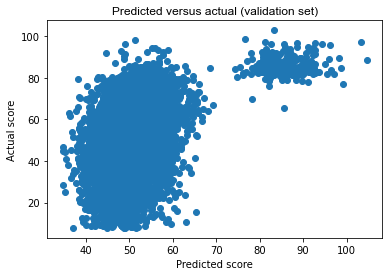

In [428]:
fig, ax = plt.subplots()
plt.scatter(y_pred4,y_val4)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

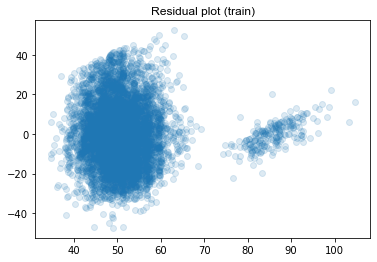

In [429]:
plt.scatter(check4['pred'],check4['resid'],alpha = 0.15)
plt.title('Residual plot (train)',family='arial',fontsize=12);